# 6. Image Segmentation (Carvana)

Оригинал (не доступен): https://www.kaggle.com/competitions/carvana-image-masking-challenge

Рабочая копия (был использован в этой работе): https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.math import reduce_sum

from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import load_model

from pathlib import Path
from tqdm.notebook import tqdm
from IPython.display import clear_output

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
DATA_PATH = Path('./data/carvana/')

MODEL_PATH = './models/carvana_best.h5'
BATCH_SIZE = 32

## Загрузка и подготовка данных

In [3]:
image_folder = DATA_PATH / 'train_images'
masks_folder = DATA_PATH / 'train_masks'

In [4]:
data = {
    'image': [],
    'mask': []
}

for img in image_folder.iterdir():
    mask = masks_folder / img.with_suffix('.png').name
    data['image'].append(str(img))
    data['mask'].append(str(mask) if mask.exists() else np.nan)

data = pd.DataFrame(data)
na_count = sum(data['mask'].isna())
print(f'Изображений без маски: {na_count}')

data.sample(5)

Изображений без маски: 0


,image,mask
2647,data\carvana\train_images\79a7691a90b1_08.jpg,data\carvana\train_masks\79a7691a90b1_08.png
333,data\carvana\train_images\120c1dc7b116_14.jpg,data\carvana\train_masks\120c1dc7b116_14.png
4826,data\carvana\train_images\f591b4f2e006_11.jpg,data\carvana\train_masks\f591b4f2e006_11.png
2226,data\carvana\train_images\69fba9e8f572_03.jpg,data\carvana\train_masks\69fba9e8f572_03.png
1151,data\carvana\train_images\3627b6f4c16d_16.jpg,data\carvana\train_masks\3627b6f4c16d_16.png


In [5]:
def load_image(path, img_size=(128, 192)):
    image = utils.load_img(path,
                           target_size=img_size,
                           keep_aspect_ratio=False)
    arr = utils.img_to_array(image)
    return arr

In [6]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask = mask.max(axis=2, keepdims=True)
    return image, mask

In [7]:
def load_data(data):
    img_size=(128, 192)

    image = load_image(data['image'], img_size)
    mask = load_image(data['mask'], img_size)

    image, mask = normalize(image, mask)
    return image, mask

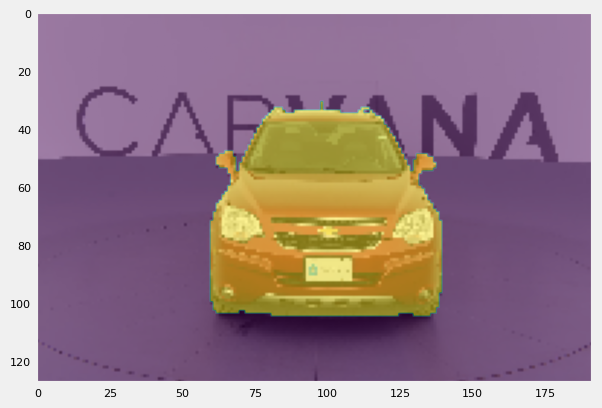

In [8]:
image, mask = load_data(data.iloc[32])
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.grid(False)
plt.show()

In [9]:
images, masks = [], []
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    image, mask = load_data(row)
    images.append(image)
    masks.append(mask)

images, masks = np.array(images), np.array(masks)

  0%|          | 0/5088 [00:00<?, ?it/s]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, masks,
                                                    test_size=0.2,
                                                    shuffle=True)

In [11]:
X_train.shape, y_train.shape

((4070, 128, 192, 3), (4070, 128, 192, 1))

## Модель (Unet)

In [12]:
def dice_coef(y_true, y_pred):
    return (2.0 * reduce_sum(y_true * y_pred) + 1.0) / (reduce_sum(y_true) + reduce_sum(y_pred) + 1.0)

In [13]:
def Unet(num_classes=1, input_shape=(200, 600, 3)):
    img_input = Input(input_shape)
    
    # Блок 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_1_out) # 100x300
    
    # Блок 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_2_out) # 50x150
    
    # Блок 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) # 25x75
    
    # Блок 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # 50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Классификатор
    activation_ = 'sigmoid' if num_classes == 1 else 'softmax'
    loss_ = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'

    x = Conv2D(num_classes, (3, 3), activation=activation_, padding='same')(x)
    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss=loss_,
                  metrics=[dice_coef])
    return model

In [14]:
model = Unet(1, (128, 192, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 192, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 192, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

                                                                                                  
 activation_9 (Activation)      (None, 16, 24, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 32, 48, 256)  524544     ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 48, 256)  1024       ['conv2d_transpose[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 activation_10 (Activation)     (None, 32, 48, 256)  0           ['batch_normalization_10[0][0]'] 
          

 conv2d_6 (Conv2D)              (None, 128, 192, 1)  577         ['activation_18[0][0]']          
                                                                                                  
Total params: 10,663,873
Trainable params: 10,655,809
Non-trainable params: 8,064
__________________________________________________________________________________________________


## Обучение модели

In [15]:
class DisplayCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        idx = np.random.randint(0, X_test.shape[0])
        y_pred = self.model.predict(X_test[idx:idx+1])[0]

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(X_test[idx])
        plt.imshow(y_pred, alpha=0.5)
        plt.title('Pred')
        plt.grid(False)

        plt.subplot(1, 2, 2)
        plt.imshow(X_test[idx])
        plt.imshow(y_test[idx], alpha=0.5)
        plt.title('Real')
        plt.grid(False)
        
        plt.show()

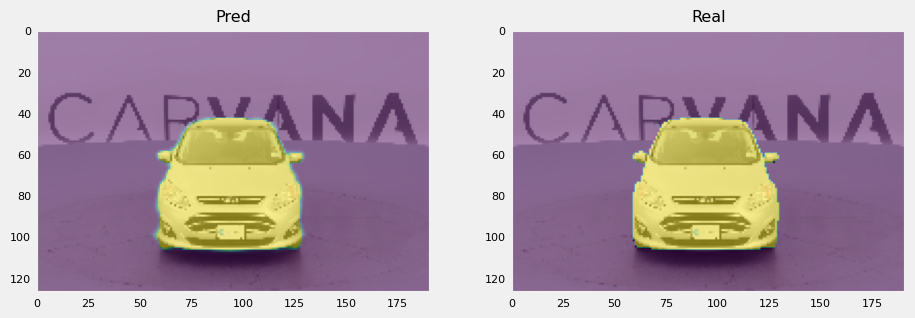

128/128 [==============================] - 73s 568ms/step - loss: 0.0106 - dice_coef: 0.9854 - val_loss: 0.0120 - val_dice_coef: 0.9830


In [16]:
callbacks = [
    DisplayCallback(),
    ModelCheckpoint(MODEL_PATH,
                    monitor='val_dice_coef',
                    save_best_only=True,
                    mode='max')
]
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

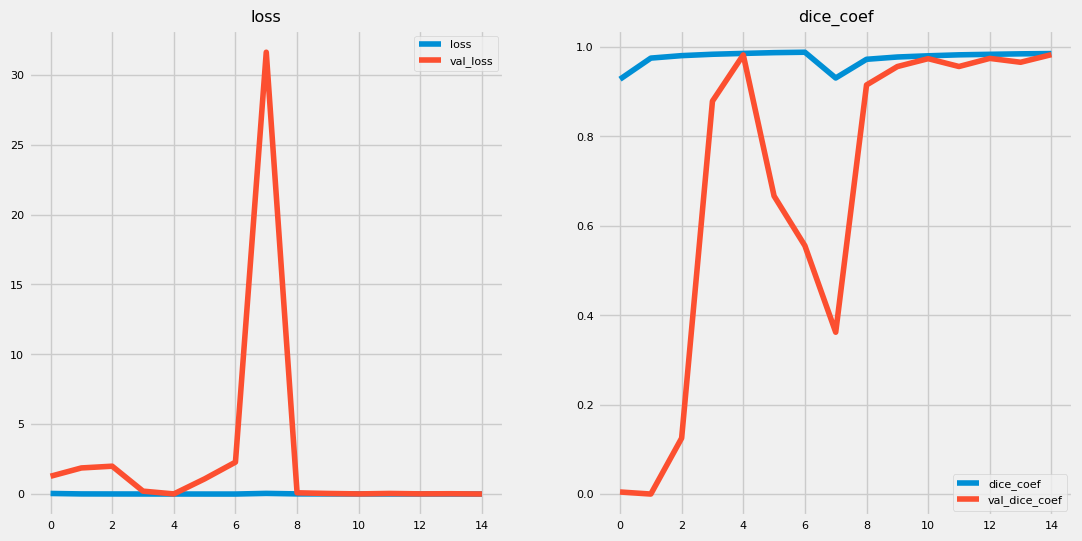

In [17]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    for i, key in enumerate(['loss', 'dice_coef']):
        plt.subplot(1, 2, i+1)
        plt.plot(history[key], label=key)
        plt.plot(history['val_'+key], label='val_'+key)
        plt.title(key)
        plt.grid(True)
        plt.legend()

    plt.show()

plot_history(history.history)

1/1 [==============================] - 0s 149ms/step


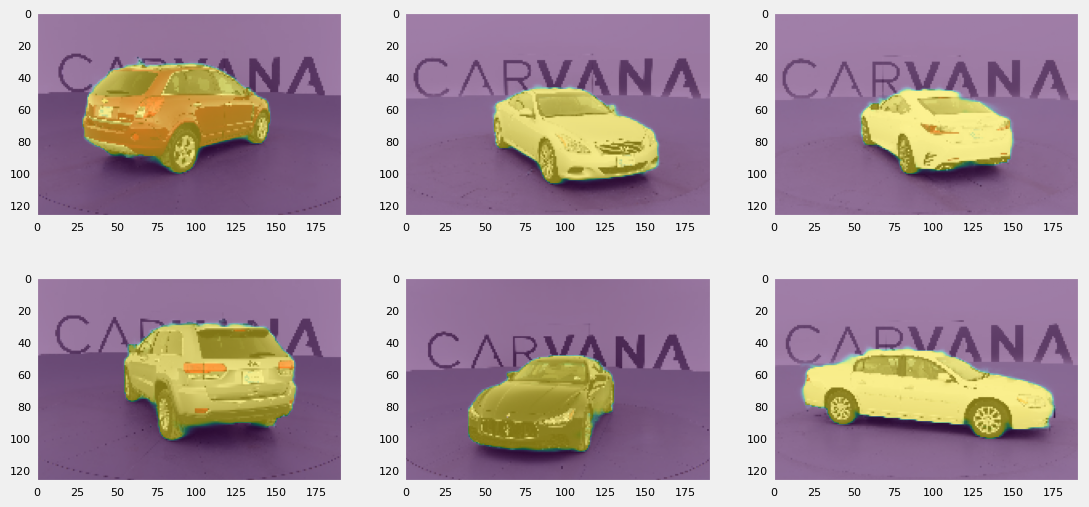

In [18]:
best_model = load_model(MODEL_PATH, custom_objects={'dice_coef': dice_coef})
test_imgs = np.random.randint(0, X_test.shape[0], size=6)
pred = best_model.predict(X_test[test_imgs])

plt.figure(figsize=(12, 6))

for num, i in enumerate(test_imgs):
        plt.subplot(2, 3, num+1)
        plt.imshow(X_test[i])
        plt.imshow(pred[num], alpha=0.5)
        plt.grid(False)

plt.show()